# Networkx Advanced Concepts

Parts of this tutorial were adapted from the material associated with the textbook "A First Course in Network Science" by Filippo Menczer, Santo Fortunato & Clayton A. Davis. You can find the materials for a deeper dive here: https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience and the book here: https://www.cambridge.org/us/universitypress/subjects/physics/statistical-physics/first-course-network-science

In [1]:
import networkx as nx
%matplotlib inline

We will now look into more advanced Graph theory concepts, namely:

1. Paths
2. Connected components
3. Directed paths
4. Hubs 
5. Centrality Measures

# 1. Paths

Let's start with a very simple, undirected network.

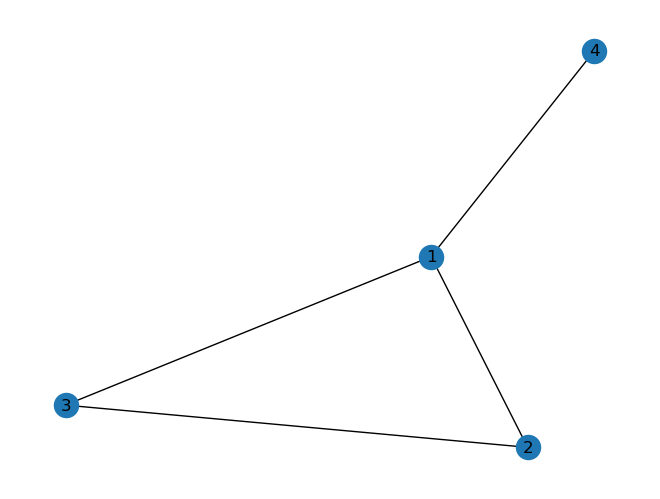

In [2]:
G = nx.Graph()

G.add_nodes_from([1,2,3,4])

G.add_edges_from([(1,2),(2,3),(1,3),(1,4)])

nx.draw(G, with_labels=True)

A *path* in a network is a sequence of edges connecting two nodes. In this simple example, we can easily see that there is indeed at least one path that connects nodes 3 and 4. We can verify this with NetworkX:

In [3]:
nx.has_path(G, 3, 4)

True

There can be more than one path between two nodes. Again considering nodes 3 and 4, there are two such "simple" paths:

In [4]:
list(nx.all_simple_paths(G, 3, 4))

[[3, 2, 1, 4], [3, 1, 4]]

A simple path is one without any cycles. If we allowed cycles, there would be infinitely many paths because one could always just go around the cycle as many times as desired.

We are often most interested in *shortest* paths. In an unweighted network, the shortest path is the one with the fewest edges. We can see that of the two simple paths between nodes 3 and 4, one is shorter than the other. We can get this shortest path with a single NetworkX function:

In [5]:
nx.shortest_path(G, 3, 4)

[3, 1, 4]

If you only care about the path length, there's a function for that too:

In [6]:
nx.shortest_path_length(G, 3, 4)

2

Note that a path length is defined here by the number of *edges* in the path, not the number of nodes, which implies

    nx.shortest_path_length(G, u, v) == len(nx.shortest_path(G, u, v)) - 1
    
for nodes $u$ and $v$.

## 2. Connected components

In the simple network above, we can see that for *every* pair of nodes, we can find a path connecting them. This is the definition of a *connected* graph. We can check this property for a given graph:

In [7]:
nx.is_connected(G)

True

Not every graph is connected:

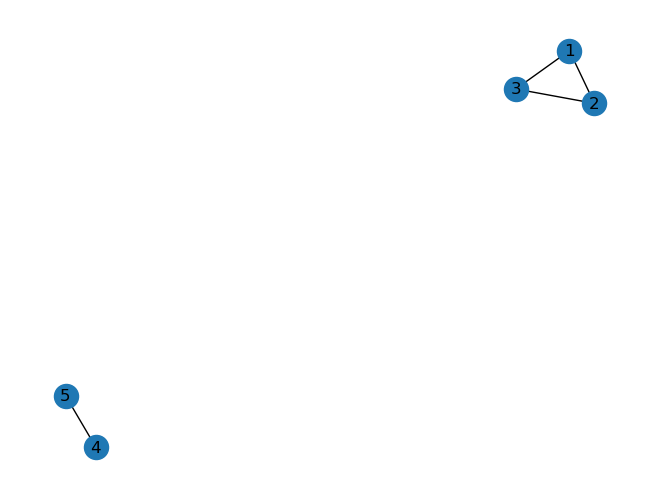

In [8]:
G = nx.Graph()

nx.add_cycle(G, (1,2,3))
G.add_edge(4,5)

nx.draw(G, with_labels=True)

In [9]:
nx.is_connected(G)

False

And NetworkX will raise an error if you ask for a path between nodes where none exists:

In [10]:
nx.has_path(G, 3, 5)

False

In [11]:
nx.shortest_path(G, 3, 5)

NetworkXNoPath: No path between 3 and 5.

Visually, we can identify two connected components in our graph. Let's verify this:

In [12]:
nx.number_connected_components(G)

2

The `nx.connected_components()` function takes a graph and returns a list of sets of node names, one such set for each connected component. Verify that the two sets in the following list correspond to the two connected components in the drawing of the graph above:

In [13]:
list(nx.connected_components(G))

[{1, 2, 3}, {4, 5}]

In case you're not familiar with Python sets, they are collections of items without duplicates. These are useful for collecting node names because node names should be unique. As with other collections, we can get the number of items in a set with the `len` function:

In [14]:
components = list(nx.connected_components(G))
len(components[0])

3

We often care about the largest connected component, which is sometimes referred to as the *core* of the network. We can make use of Python's builtin `max` function in order to obtain the largest connected component. By default, Python's `max` function sorts things in lexicographic (i.e. alphabetical) order, which is not helpful here. We want the maximum connected component when sorted in order of their sizes, so we pass `len` as a key function:

In [15]:
max(nx.connected_components(G), key=len)

{1, 2, 3}

While it's often enough to just have the list of node names, sometimes we need the actual subgraph consisting of the largest connected component. One way to get this is to pass the list of node names to the `G.subgraph()` function:

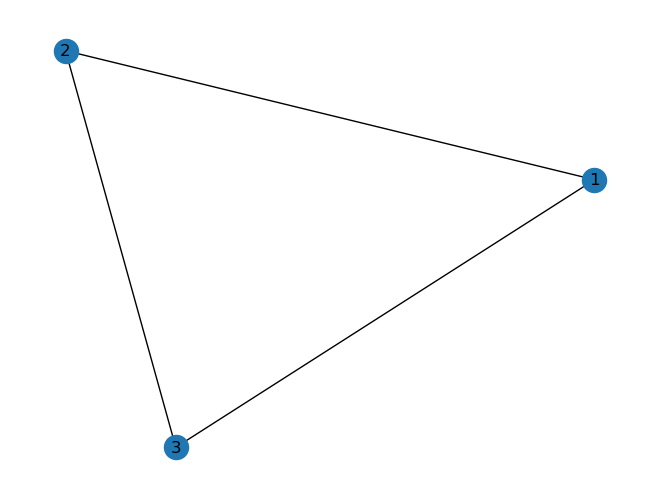

In [16]:
core_nodes = max(nx.connected_components(G), key=len)
core = G.subgraph(core_nodes)

nx.draw(core, with_labels=True)

Those of you using tab-completion will also notice a `nx.connected_component_subgraphs()` function. This can also be used to get the core subgraph but the method shown is more efficient when you only care about the largest connected component.

# 3. Directed paths

Let's extend these ideas to directed graphs.

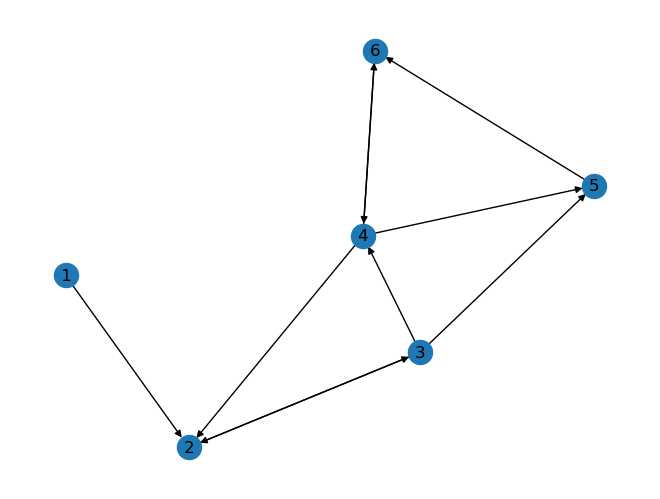

In [17]:
D = nx.DiGraph()
D.add_edges_from([
    (1,2),
    (2,3),
    (3,2), (3,4), (3,5),
    (4,2), (4,5), (4,6),
    (5,6),
    (6,4),
])
nx.draw(D, with_labels=True)

We know that in a directed graph, an edge from an arbitrary node $u$ to an arbitrary node $v$ does not imply that an edge exists from $v$ to $u$. Since paths must follow edge direction in directed graphs, the same asymmetry applies for paths. Observe that this graph has a path from 1 to 4, but not in the reverse direction.

In [18]:
nx.has_path(D, 1, 4)

True

In [19]:
nx.has_path(D, 4, 1)

False

The other NetworkX functions dealing with paths take this asymmetry into account as well:

In [20]:
nx.shortest_path(D, 2, 5)

[2, 3, 5]

In [21]:
nx.shortest_path(D, 5, 2)

[5, 6, 4, 2]

Since there is no edge from 5 to 3, the shortest path from 5 to 2 cannot simply backtrack the shortest path from 2 to 5 -- it has to go a longer route through nodes 6 and 4.

## 4. Finding hubs

Often when looking at a network, we want to find the most "important" nodes, for some definition of important. The most basic measure of centrality is the *degree*, or number of links attached to a node.

We will use data about characters in the novel 'A Song of Ice and Fire' (ASOIAF). You can obtain the dataset from the [GitHub repository](https://github.com/mathbeveridge/asoiaf) maintained by Mathew A. Beveridge. The dataset is available in CSV format.

Number of nodes 796
Number of edges 2823
Average degree 7.092964824120603


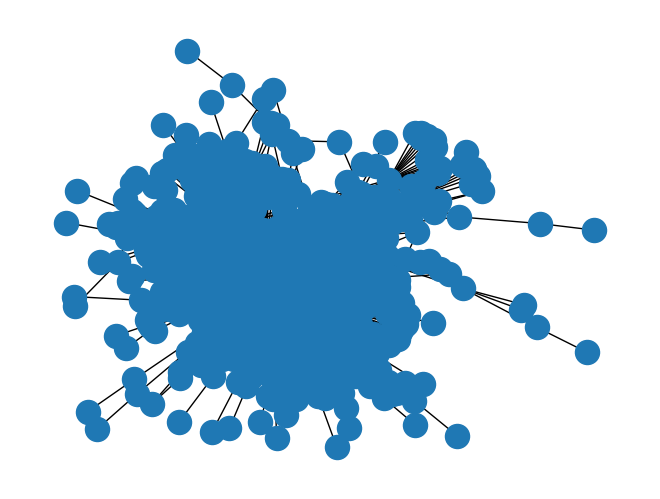

In [45]:
import pandas as pd
asoiaf_data = 'https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-all-edges.csv'
df = pd.read_csv(asoiaf_data)

# Create a graph
G = nx.from_pandas_edgelist(df, 'Source', 'Target')
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))
nx.draw(G)

#### What do the edges mean?

Two characters have an edge whenever their names (or nicknames) appeared within 15 words of one another in one of the books in "A Song of Ice and Fire." The edge weight corresponds to the number of interactions. **We do not consider the edge weights for the tutorial or the direction.**

In [98]:
list(G.edges)[0:5]

[('Addam-Marbrand', 'Brynden-Tully'),
 ('Addam-Marbrand', 'Cersei-Lannister'),
 ('Addam-Marbrand', 'Gyles-Rosby'),
 ('Addam-Marbrand', 'Jaime-Lannister'),
 ('Addam-Marbrand', 'Jalabhar-Xho')]

### Caveat: by default, `nx.read_edgelist` assumes node names are strings

Edge lists are a simple, plain text format for storing graphs. Since this simple file format doesn't contain information about data types, all node names are assumed to be strings by default. When the node names are given by integers, as they are in this example, we should specify the `nodetype=int` keyword argument to avoid confusion with the node names.

### Finding the node with max degree

We can apply the `max` function to get the maximum node according to some criterion. In our case, we want to compare the nodes by their degree:

In [46]:
highest_degree_node = max(G.nodes, key=G.degree)
highest_degree_node

'Tyrion-Lannister'

In [47]:
G.degree(highest_degree_node)

122

So we know that Tyrion has 122 edges. Let's look at that calculation a little closer:

```python
max(G.nodes, key=G.degree)
```

We're telling the `max` function that we want the item from `G.nodes` that gives us the highest value when passed to the *key* function `G.degree`.

This construction works because `G.degree` is a function. Some other measures of centrality such as betweenness generate all of the nodes' centrality values at once and return a `dict`. In this case, we need an extra step:

Another concept of node importance is 'betweenness' centrality. It involves calculating how often a node lies on the shortest path between other pairs of nodes. Nodes with high betweenness centrality are good 'brokers'.

In [48]:
betweenness = nx.centrality.betweenness_centrality(G)
highest_betweenness_node = max(G.nodes, key=betweenness.get)
highest_betweenness_node

'Jon-Snow'

In [49]:
betweenness[highest_betweenness_node]

0.1921196196835449

## 5. Centrality distributions

We've found the most central node in the network, but often we want to summarize information about the centrality of all nodes. For example, in addition to the maxmimum degree, we often want the mean and median degree in a network.

The first step in summarizing this information is to get a sequence of all of the centrality values in the graph. We don't care about the node names anymore, we just want a sequence of numbers. We can start with the example of degree:

In [50]:
degree_sequence = [G.degree(n) for n in G.nodes]

To get the mean and median of this sequence, we can use Python's built-in `statistics` module:

In [51]:
import statistics

print('Mean degree:', statistics.mean(degree_sequence))
print('Median degree:', statistics.median(degree_sequence))

Mean degree: 7.092964824120603
Median degree: 3.0


For other measures of centrality, which are calculated for the whole network at once and return a dict, we can use the dict's `.values()`.

In [52]:
betweenness = nx.centrality.betweenness_centrality(G)
betweenness_sequence = list(betweenness.values())

print('Mean betweenness:', statistics.mean(betweenness_sequence))
print('Median betweenness:', statistics.median(betweenness_sequence))

Mean betweenness: 0.003043105520154994
Median betweenness: 4.058934480492391e-06


### Plotting the distribution

We can graphically represent the sequence of centrality values by using a *histogram*. In its basic form, a histogram plots the degree values on the x-axis, and the number of nodes having that degree on the y-axis. To do this counting, we can make use of Python's `collections.Counter`.

In [53]:
from collections import Counter

degree_counts = Counter(degree_sequence)
degree_counts

Counter({1: 187,
         2: 146,
         3: 86,
         4: 69,
         5: 56,
         6: 39,
         9: 27,
         7: 25,
         8: 24,
         11: 13,
         13: 12,
         12: 10,
         10: 9,
         15: 8,
         18: 7,
         14: 7,
         19: 6,
         20: 6,
         17: 4,
         23: 4,
         33: 4,
         21: 4,
         22: 4,
         16: 3,
         28: 3,
         24: 3,
         75: 2,
         74: 2,
         26: 2,
         25: 2,
         30: 2,
         97: 1,
         101: 1,
         69: 1,
         122: 1,
         48: 1,
         34: 1,
         73: 1,
         89: 1,
         114: 1,
         65: 1,
         44: 1,
         84: 1,
         66: 1,
         41: 1,
         45: 1,
         54: 1,
         38: 1,
         36: 1,
         47: 1,
         27: 1})

The `Counter` object returned is like a dict, pairing the item counted with the number of times it showed up in the sequence.

On this basic histogram plot, we want an x-value for every integer between the minimum and maximum degree in the sequence, inclusive. Note that `degree_counts.keys()` gives us every distinct value seen in the degree sequence. Also note that we need the +1 in the `range` below because we want to include the right endpoint.

In [54]:
min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())

plot_x = list(range(min_degree, max_degree + 1))

Our y-values are then the number of times we counted each x-value in the degree sequence. We can make use of the `.get` method with a default value in order to count 0 for degree values that don't show up in the sequence. For example, notice that 32 does not show up in `degree_counts` above, so `degree_counts.get(32, 0)` will give us 0.

In [55]:
plot_y = [degree_counts.get(x, 0) for x in plot_x]

To do the plotting, we use Matplotlib's `pyplot` module.

<BarContainer object of 122 artists>

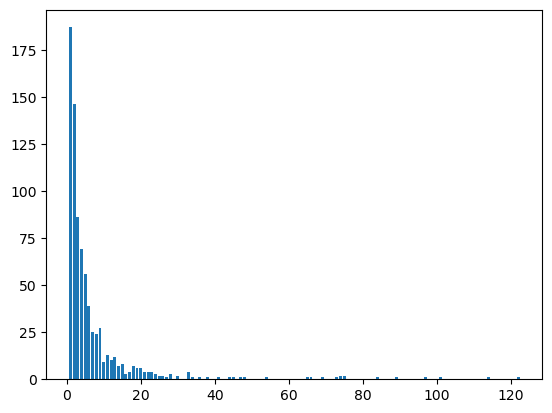

In [56]:
import matplotlib.pyplot as plt

plt.bar(plot_x, plot_y)

This is a typical power law distribution with very few people having centrality, while most have little.

### Highlight the most central nodes

In [59]:
betweenness

{'Addam-Marbrand': 0.00046968169281068643,
 'Brynden-Tully': 0.0022270360075842487,
 'Cersei-Lannister': 0.08870426655860289,
 'Gyles-Rosby': 0.00041544063958593114,
 'Jaime-Lannister': 0.10083800602581632,
 'Jalabhar-Xho': 0.000806839904414349,
 'Joffrey-Baratheon': 0.03175872220136575,
 'Kevan-Lannister': 0.0018933081396063087,
 'Lyle-Crakehall': 9.037647220243105e-06,
 'Oberyn-Martell': 0.009803338344122527,
 'Tyrion-Lannister': 0.1621910961115984,
 'Tywin-Lannister': 0.020669858406317167,
 'Varys': 0.009201379313719161,
 'Aegon-Frey-(son-of-Stevron)': 0.0,
 'Catelyn-Stark': 0.054973667953404186,
 'Robb-Stark': 0.06646842683586629,
 'Stevron-Frey': 2.6403476809826316e-06,
 'Walder-Frey': 0.006634157224487359,
 'Aegon-I-Targaryen': 0.006891001543130115,
 'Daenerys-Targaryen': 0.11841801916269204,
 'Eddard-Stark': 0.07873239257251873,
 'Harren-Hoare': 7.666810865224729e-05,
 'Nan': 0.0007144613988157187,
 'Rhaenys-Targaryen': 0.0,
 'Stannis-Baratheon': 0.11013955266679566,
 'Torrhen-S

In [99]:
hubs = [n for n in G.nodes if betweenness[n] > 0.1] # this is an arbitrary threshold

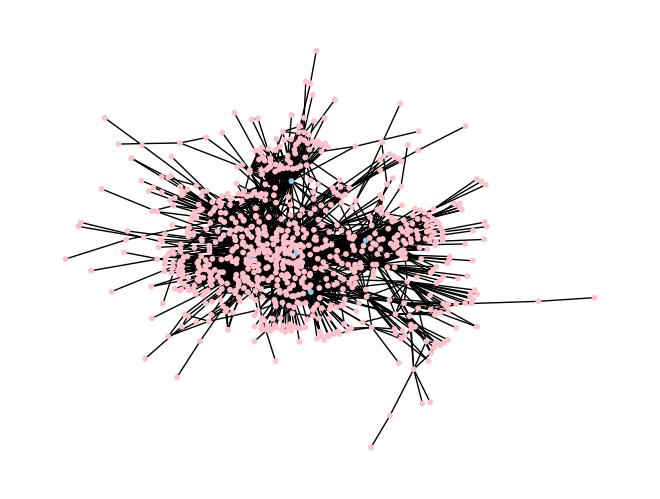

In [102]:
node_colors = ['skyblue' if n in hubs else 'pink' for n in G.nodes]
        
nx.draw(G, node_color=node_colors, node_size = 10)

let's try to increase the size of the hubs and label them

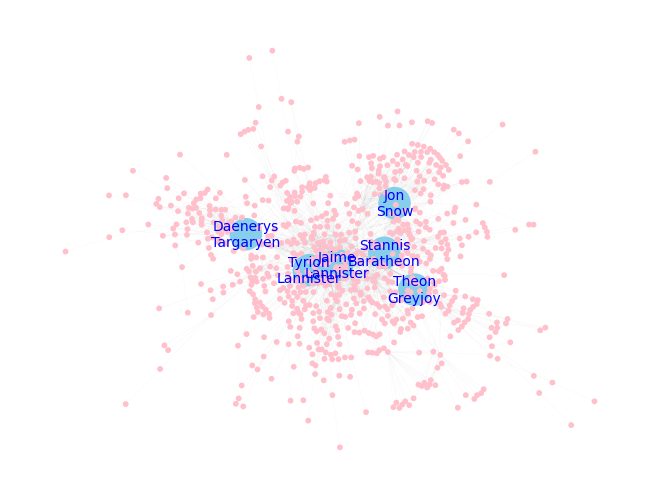

In [104]:
hub_labels = {} # dictionary with keys as nodes and values as nodes as well   
node_sizes = [] # list of sizes

for node in G.nodes():
    if node in hubs:
        hub_labels[node] = '\n'.join(str(node).split('-'))
        node_sizes.append(500)
    else:
        hub_labels[node] = '' # set to a blank label if not a hub
        node_sizes.append(10)

nx.draw(G, with_labels = True, labels = hub_labels,
        width = 0.01, # make the edges lighter
        node_color = node_colors, node_size = node_sizes,
        font_color='blue', font_size = 10)

More on networkx drawing: https://memgraph.github.io/networkx-guide/visualization/basics/